<a href="https://colab.research.google.com/github/masoudshahrian/Deep-Learning-Code/blob/main/Face_Inpainting_Using_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import cv2

In [ ]:
PATH="/content/drive/MyDrive/Imagetest"
# مسیر پوشه حاوی تصاویر اصلی
input_folder = PATH #''path_to_your_image_folder'

# تنظیمات برای ابعاد تصاویر
IMG_WIDTH = 128
IMG_HEIGHT = 128

# لیست برای ذخیره تصاویر و لیبل‌ها
X = []
y = []

# پردازش تصاویر در پوشه ورودی
for filename in os.listdir(input_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT))

        # محاسبه نقطه وسط ارتفاع تصویر
        width, height = img.size
        mid_height = height // 2

        # برش نیمه بالا و پایین
        upper_half = img.crop((0, 0, width, mid_height))
        lower_half = img.crop((0, mid_height, width, height))

        # تبدیل تصاویر به آرایه‌های numpy
        X.append(np.array(upper_half))
        y.append(np.array(lower_half))

# تبدیل لیست‌ها به آرایه‌های numpy
X = np.array(X) / 255.0  # نرمال‌سازی تصاویر
y = np.array(y) / 255.0  # نرمال‌سازی تصاویر


In [ ]:

# تقسیم داده‌ها به مجموعه‌های آموزشی و تست
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# ساخت مدل U-Net
def unet_model(input_size=(mid_height, IMG_WIDTH, 3)):
# def unet_model(input_size=(mid_height, IMG_WIDTH, mid_height * IMG_WIDTH * 3)):

    inputs = tf.keras.Input(input_size)

    # Downsampling
    c1 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.2)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.3)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.3)(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.4)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    # Upsampling
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.3)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.3)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.2)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c9)

    # outputs = layers.Dense(mid_height * IMG_WIDTH * 3, activation='sigmoid')(c9)

    # outputs = layers.Reshape((mid_height, IMG_WIDTH, 3))(outputs)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

# ساخت مدل U-Net
model = unet_model()

# کامپایل مدل
model.compile(optimizer='adam', loss='mean_squared_error')
             # loss='binary_crossentropy')
              # loss='mean_squared_error')
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 3)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 128, 64)    │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 128, 64)    │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 128, 64)    │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 64, 128)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 64, 128)    │        147,584 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 16, 32, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 32, 256)    │        590,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 8, 16, 256)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 8, 16, 512)     │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 8, 16, 512)     │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 8, 16, 512)     │      2,359,808 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 4, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 31,031,875 (118.38 MB)

 Trainable params: 31,031,875 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# آموزش مدل
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)


In [ ]:
# ارزیابی مدل
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


# ذخیره مدل
model.save('UNet_model.h5')


In [ ]:
# @title Save Model
upper_half= X_train
lower_half= y_train
# ذخیره مدل
# model.save('UNet_model.h5')


134/134 [==============================] - 14s 105ms/step


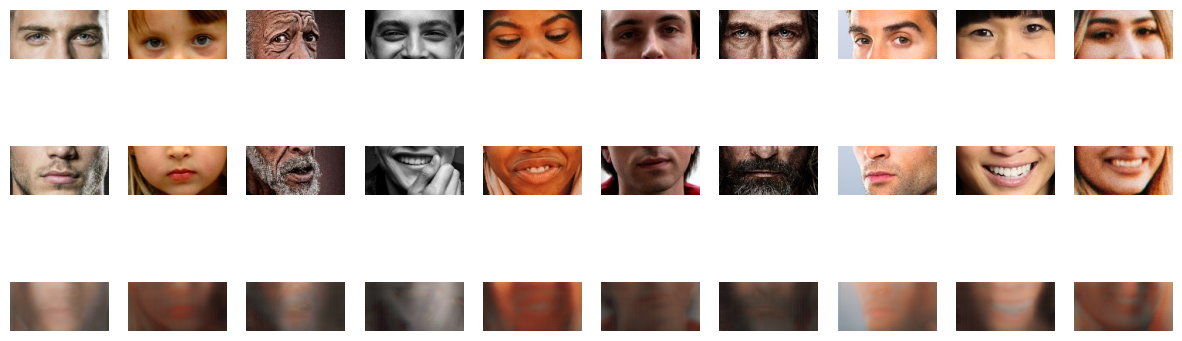

In [ ]:
# @title Showing All results

# Showing results
def display_results(model, upper_half, lower_half):
    predictions = model.predict(lower_half)
    # predictions = model.predict(upper_half)

    fig, axes = plt.subplots(3, 10, figsize=(15, 5))
    for i in range(10):
        axes[0, i].imshow(upper_half[i])
        axes[0, i].axis('off')
        axes[1, i].imshow(lower_half[i])
        axes[1, i].axis('off')
        axes[2, i].imshow(predictions[i])
        axes[2, i].axis('off')
    plt.show()

display_results(model, upper_half, lower_half)

In [ ]:
# @title Adding Specific Image
import cv2
def load_and_preprocess_image(image_path, img_size=(128, 128)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    return img
def split_image(img):
    h, w, _ = img.shape
    lower_half = img[h//2:, :]
    return lower_half

def split_image2(img):
    h, w, _ = img.shape
    upper_half = img[:h//2, :]
    return upper_half

def combine_and_display(upper_half, lower_half_pred):
    full_face = np.vstack((upper_half, lower_half_pred))
    plt.imshow(full_face)
    plt.axis('off')
    plt.show()


'''-----------------------------------------------------------------------------'''
# Load Model of Images
loaded_model = tf.keras.models.load_model('UNet_model.h5')

'''-----------------------------------------------------------------------------'''

# Path to the new image
image_path ="/content/1 (122).png"
# "/content/test1.png"# "/content/resized_image.jpg" #"/content/test1.png" #"/content/resized_image.jpg"# "/path/to/new/image.jpg"  # مسیر تصویر جدید

# Load and preprocess the new image
new_image = load_and_preprocess_image(image_path)
upper_half = split_image2(new_image)
'''-----------------------------------------------------------------------------'''

# Normalize the upper half
upper_half_normalized = upper_half / 255.0

# Predict the lower half using the model
upper_half_normalized = np.expand_dims(upper_half_normalized, axis=0)  # Add batch dimension

134/134 [==============================] - 10s 72ms/step


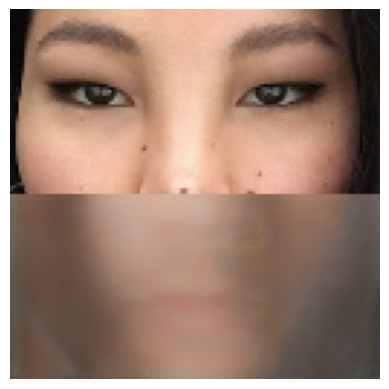

In [ ]:
# @title Merge Upper And Lower Part of Specific Image
lower_half_pred = loaded_model.predict(lower_half)[0]
result_image=lower_half_pred

result_image = (result_image * 255).astype(np.uint8)
result_image = np.concatenate((upper_half, result_image), axis=0)
# result_image = Image.fromarray(result_image)
plt.imshow(result_image)
plt.axis('off')
plt.show()


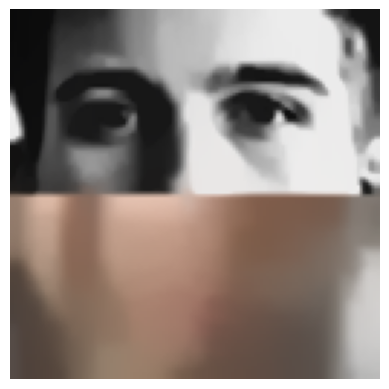

In [ ]:
# @title Final Result

import cv2
import numpy as np
image=result_image
image = cv2.GaussianBlur(image, (5, 5), 0)
image = cv2.detailEnhance(image, sigma_s=10, sigma_r=0.15)
image = cv2.edgePreservingFilter(image, flags=1, sigma_s=60, sigma_r=0.4)
plt.imshow(image)
plt.axis('off')
plt.show()
